In [142]:
from vega import Vega
import json
import altair as alt

import pandas as pd
artefacts_df = pd.read_csv("artefacts-overview-stats.csv")
artefacts_non_nature_df = artefacts_df.loc[artefacts_df['topic'] != 'nature']
artefacts_museum_df = artefacts_df.loc[artefacts_df['type'] == 'museum']

# Overview

*WORK IN PROGRESS - Updated Aug 2024*

In [143]:
from collections import Counter

tree_totals = artefacts_df.groupby('type').sum(numeric_only=True)
tree_structure = [ { "id": 1, "name": "National Collection" } ]
tree_node_index = 2
#tree_totals.columns
parent_map = {}
for row in tree_totals.iterrows():
  parent_map[row[0]] = tree_node_index
  tree_structure.append({"id": tree_node_index, "name": row[0], 
                         "parent": 1})
  tree_node_index+= 1


institution_type_index = Counter()
for i, row in artefacts_df.iterrows():
    tree_structure.append({"id": tree_node_index, "name": row["institution"], 
                           "size": int(row["artefact_count"]), 
                         "parent": parent_map[row['type']]})
    institution_type_index[row["type"]] += 1
    tree_node_index+=1

In [352]:
treemap_test_spec = f"""
{{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "An example of treemap layout for hierarchical data.",
  "width": 960,
  "height": 600,
  "padding": 2.5,
  "autosize": "none",
  "signals": [
  ],
  "data": [
    {{
      "name": "tree",
      "values": {json.dumps(tree_structure)},
      "transform": [
        {{"type": "stratify", "key": "id", "parentKey": "parent"}},
        {{
          "type": "treemap",
          "field": "size",
          "sort": {{"field": "value"}},
          "round": true,
          "method": "squarify",
          "ratio": 1.6,
          "size": [{{"signal": "width"}}, {{"signal": "height"}}]
        }}
      ]
    }},
    {{
      "name": "nodes",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "datum.children"}}]
    }},
    {{
      "name": "leaves",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "!datum.children"}}]
    }},
    {{
      "name": "large-leaves",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "!datum.children && datum.size > 2500000"}}]
    }},
    {{
      "name": "total",
      "source": "tree",
      "transform": [{{"type": "aggregate", "fields": ["size"], "ops": ["sum"], "as": ["totalsize"]}}]
      }},
  {{
      "name": "percentages",
      "source": "tree",
      "transform":  [
      {{ "type": "lookup","from": "total","key": "id","fields": ["totalsize"],"values": ["totalsize"]   }},
      {{"type": "formula", "expr": "datum.name + ' ' + format((datum.size/datum.totalsize), ',.1%')", "as": "nc_percent"}}
      ]
    }}
  ],
  "scales": [
    {{
      "name": "color",
      "type": "ordinal",
      "domain": {{"data": "nodes", "field": "name"}},
      "range": [
        "#3182bd",
        "#6baed6",
        "#9ecae1",
        "#c6dbef",
        "#e6550d",
        "#fd8d3c",
        "#fdae6b",
        "#fdd0a2",
        "#31a354",
        "#74c476",
        "#a1d99b",
        "#c7e9c0",
        "#756bb1",
        "#9e9ac8",
        "#bcbddc",
        "#dadaeb",
        "#636363",
        "#969696",
        "#bdbdbd",
        "#d9d9d9"
      ]
    }},
    {{
      "name": "size",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [0, 0, 0, 0]
    }},
    {{
      "name": "collection-size",
      "type": "quantile",
      "domain": [0, 1000, 10000, 100000, 1000000, 2500000, 5000000, 20000000],
      "range": [0, 0, 0, 0, 5, 7, 11, 16]
    }},
    {{
      "name": "opacity",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [0, 0, 0.8, 1]
    }}
  ],
  "marks": [
    {{
      "type": "rect",
      "from": {{"data": "nodes"}},
      "interactive": false,
      "encode": {{
        "enter": {{"fill": {{"scale": "color", "field": "name"}} }},
        "update": {{
          "x": {{"field": "x0"}},
          "y": {{"field": "y0"}},
          "x2": {{"field": "x1"}},
          "y2": {{"field": "y1"}}
        }}
      }}
    }},
    {{
      "type": "rect",
      "from": {{"data": "leaves"}},
      "encode": {{
        "enter": {{"stroke": {{"value": "#fff"}},
                  "tooltip": {{ "field": "name" }}
        }},
        "update": {{
          "x": {{"field": "x0"}},
          "y": {{"field": "y0"}},
          "x2": {{"field": "x1"}},
          "y2": {{"field": "y1"}},
          "fill": {{"value": "transparent"}}
        }},
        "hover": {{"fill": {{"value": "#efb118"}} }}
      }}
    }},
    {{
      "type": "text",
      "from": {{"data": "nodes"}},
      "interactive": false,
      "encode": {{
        "enter": {{
          "font": {{"value": "Helvetica Neue, Arial"}},
          "align": {{"value": "center"}},
          "baseline": {{"value": "middle"}},
          "fill": {{"value": "#000"}},
          "text": {{"field": "name"}},
          "fontSize": {{"scale": "size", "field": "depth"}},
          "fillOpacity": {{"scale": "opacity", "field": "depth"}}
        }},
        "update": {{
          "x": {{"signal": "0.5 * (datum.x0 + datum.x1)"}},
          "y": {{"signal": "0.5 * (datum.y0 + datum.y1)"}}
        }}
      }}
    }},  
    {{
      "type": "text",
      "from": {{"data": "percentages"}},
      "interactive": false,
      "encode": {{
        "enter": {{
          "font": {{"value": "Helvetica Neue, Arial"}},
          "align": {{"value": "center"}},
          "baseline": {{"value": "middle"}},
          "fill": {{"value": "#000"}},
          "text": {{"field": "name"}},
          "fontSize": {{"scale": "collection-size", "field": "size"}},
          "fillOpacity": {{"scale": "opacity", "field": "depth"}}
        }},
        "update": {{
          "x": {{"signal": "0.5 * (datum.x0 + datum.x1)"}},
          "y": {{"signal": "0.46 * (datum.y0 + datum.y1)"}},
          "text": {{"signal": "split(datum.nc_percent, ' ')"}}
        }}
      }}
    }}
  ]
}}
"""

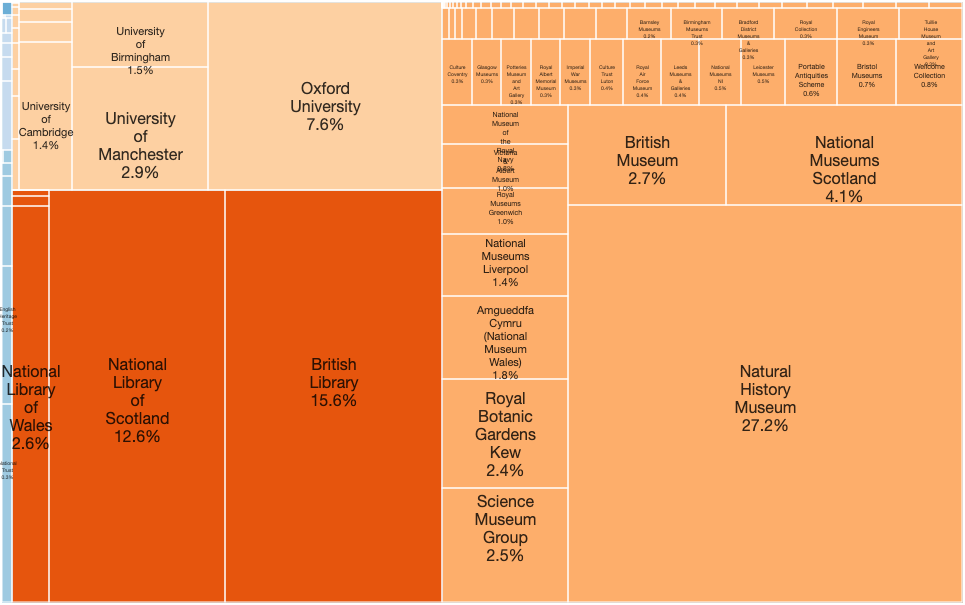

In [356]:
from IPython.display import display
import json
display({"application/vnd.vega.v5+json": json.loads(treemap_test_spec)}, 
         metadata={
    "application/vnd.vegalite.v5+json": {
        "embed_options": {
            "actions": True
        }
    }
},  raw=True)

In [146]:
from collections import Counter

nn_tree_totals = artefacts_non_nature_df.groupby('type').sum(numeric_only=True)
nn_tree_structure = [ { "id": 1, "name": "National Collection" } ]
nn_tree_node_index = 2
#tree_totals.columns
nn_parent_map = {}
for nn_row in nn_tree_totals.iterrows():
  nn_parent_map[nn_row[0]] = nn_tree_node_index
  nn_tree_structure.append({"id": nn_tree_node_index, "name": nn_row[0], 
                         "parent": 1})
  nn_tree_node_index+= 1


nn_institution_type_index = Counter()
for nn_i, nn_row in artefacts_non_nature_df.iterrows():
    nn_tree_structure.append({"id": nn_tree_node_index, "name": nn_row["institution"], 
                           "size": int(nn_row["artefact_count"]), 
                         "parent": nn_parent_map[nn_row['type']]})
    nn_institution_type_index[nn_row["type"]] += 1
    nn_tree_node_index+=1

In [359]:
nn_treemap_test_spec = f"""
{{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "An example of treemap layout for hierarchical data.",
  "width": 960,
  "height": 500,
  "padding": 2.5,
  "autosize": "none",
  "signals": [
  ],
  "data": [
    {{
      "name": "tree",
      "values": {json.dumps(nn_tree_structure)},
      "transform": [
        {{"type": "stratify", "key": "id", "parentKey": "parent"}},
        {{
          "type": "treemap",
          "field": "size",
          "sort": {{"field": "value"}},
          "round": true,
          "method": "squarify",
          "ratio": 1.6,
          "size": [{{"signal": "width"}}, {{"signal": "height"}}]
        }}
      ]
    }},
    {{
      "name": "nodes",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "datum.children"}}]
    }},
    {{
      "name": "leaves",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "!datum.children"}}]
    }},
    {{
      "name": "total",
      "source": "tree",
      "transform": [{{"type": "aggregate", "fields": ["size"], "ops": ["sum"], "as": ["totalsize"]}}]
      }},
  {{
      "name": "percentages",
      "source": "tree",
      "transform":  [
      {{ "type": "lookup","from": "total","key": "id","fields": ["totalsize"],"values": ["totalsize"]   }},
      {{"type": "formula", "expr": "datum.name", "as": "nc_percent"}}
      ]
    }},
    {{
      "name": "large-leaves",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "!datum.children && datum.size > 2500000"}}]
    }}
  ],
  "scales": [
    {{
      "name": "color",
      "type": "ordinal",
      "domain": {{"data": "nodes", "field": "name"}},
      "range": [
        "#3182bd",
        "#6baed6",
        "#9ecae1",
        "#c6dbef",
        "#e6550d",
        "#fd8d3c",
        "#fdae6b",
        "#fdd0a2",
        "#31a354",
        "#74c476",
        "#a1d99b",
        "#c7e9c0",
        "#756bb1",
        "#9e9ac8",
        "#bcbddc",
        "#dadaeb",
        "#636363",
        "#969696",
        "#bdbdbd",
        "#d9d9d9"
      ]
    }},
    {{
      "name": "size",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [0, 20, 18, 14]
    }},
    {{
      "name": "collection-size",
      "type": "quantile",
      "domain": [0, 1000, 10000, 100000, 1000000, 2500000, 5000000, 20000000],
      "range": [0, 0, 0, 0, 5, 7, 11, 16]
    }},
    {{
      "name": "opacity",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [0, 0, 0.6, 1]
    }}
  ],
  "marks": [
    {{
      "type": "rect",
      "from": {{"data": "nodes"}},
      "interactive": false,
      "encode": {{
        "enter": {{"fill": {{"scale": "color", "field": "name"}} }},
        "update": {{
          "x": {{"field": "x0"}},
          "y": {{"field": "y0"}},
          "x2": {{"field": "x1"}},
          "y2": {{"field": "y1"}}
        }}
      }}
    }},
    {{
      "type": "rect",
      "from": {{"data": "leaves"}},
      "encode": {{
        "enter": {{"stroke": {{"value": "#fff"}},
                  "tooltip": {{ "field": "name" }}
        }},
        "update": {{
          "x": {{"field": "x0"}},
          "y": {{"field": "y0"}},
          "x2": {{"field": "x1"}},
          "y2": {{"field": "y1"}},
          "fill": {{"value": "transparent"}}
        }},
        "hover": {{"fill": {{"value": "#efb118"}} }}
      }}
    }},
    {{
      "type": "text",
      "from": {{"data": "nodes"}},
      "interactive": false,
      "encode": {{
        "enter": {{
          "font": {{"value": "Helvetica Neue, Arial"}},
          "align": {{"value": "center"}},
          "baseline": {{"value": "middle"}},
          "fill": {{"value": "#000"}},
          "text": {{"field": "name"}},
          "fontSize": {{"scale": "size", "field": "depth"}},
          "fillOpacity": {{"scale": "opacity", "field": "depth"}}
        }},
        "update": {{
          "x": {{"signal": "0.5 * (datum.x0 + datum.x1)"}},
          "y": {{"signal": "0.5 * (datum.y0 + datum.y1)"}}
        }}
      }}
    }},  
    {{
      "type": "text",
      "from": {{"data": "percentages"}},
      "interactive": false,
      "encode": {{
        "enter": {{
          "font": {{"value": "Helvetica Neue, Arial"}},
          "align": {{"value": "center"}},
          "baseline": {{"value": "middle"}},
          "fill": {{"value": "#000"}},
          "text": {{"field": "name"}},
          "fontSize": {{"scale": "collection-size", "field": "size"}},
          "fillOpacity": {{"scale": "opacity", "field": "depth"}}
        }},
        "update": {{
          "x": {{"signal": "0.5 * (datum.x0 + datum.x1)"}},
          "y": {{"signal": "0.46 * (datum.y0 + datum.y1)"}},
          "text": {{"signal": "split(datum.nc_percent, ' ')"}}
        }}
      }}
    }}
  ]
}}
"""

#### National Collection Overview (excluding specimen holding organisations)

The scale of collections held by natural history holding organisations can overwhelm data visualisations of overall UK collections, so in this area chart below they have been removed to allow more visibility of other collections.

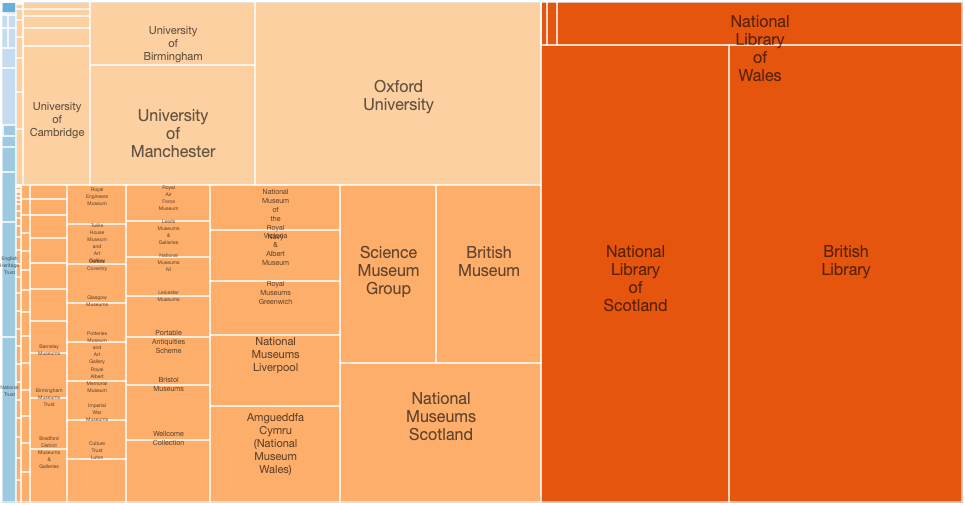

In [360]:
from IPython.display import display
import json
display({"application/vnd.vega.v5+json": json.loads(nn_treemap_test_spec)}, 
        metadata={
    "application/vnd.vegalite.v5+json": {
        "embed_options": {
            "actions": False,
            "hover": True
        }
    }
},   raw=True)

In [149]:
from collections import Counter

mus_tree_totals = artefacts_museum_df.groupby('type').sum(numeric_only=True)
mus_tree_structure = [ { "id": 1, "name": "National Collection" } ]
mus_tree_node_index = 2
#tree_totals.columns
mus_parent_map = {}
for mus_row in mus_tree_totals.iterrows():
  mus_parent_map[mus_row[0]] = mus_tree_node_index
  mus_tree_structure.append({"id": mus_tree_node_index, "name": mus_row[0], 
                         "parent": 1})
  mus_tree_node_index+= 1


mus_institution_type_index = Counter()
for mus_i, mus_row in artefacts_museum_df.iterrows():
    mus_tree_structure.append({"id": mus_tree_node_index, "name": mus_row["institution"], 
                           "size": int(mus_row["artefact_count"]), 
                         "parent": mus_parent_map[mus_row['type']]})
    mus_institution_type_index[mus_row["type"]] += 1
    mus_tree_node_index+=1

In [354]:
mus_treemap_spec = f"""
{{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "An example of treemap layout for hierarchical data.",
  "width": 960,
  "height": 500,
  "padding": 2.5,
  "autosize": "none",
  "signals": [
  ],
  "data": [
    {{
      "name": "tree",
      "values": {json.dumps(mus_tree_structure)},
      "transform": [
        {{"type": "stratify", "key": "id", "parentKey": "parent"}},
        {{
          "type": "treemap",
          "field": "size",
          "sort": {{"field": "value"}},
          "round": true,
          "method": "squarify",
          "ratio": 1.6,
          "size": [{{"signal": "width"}}, {{"signal": "height"}}]
        }}
      ]
    }},
    {{
      "name": "nodes",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "datum.children"}}]
    }},
    {{
      "name": "leaves",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "!datum.children"}}]
    }},
    {{
      "name": "large-leaves",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "!datum.children && datum.size > 200000"}}]
    }}
  ],
  "scales": [
    {{
      "name": "color",
      "type": "ordinal",
      "domain": {{"data": "nodes", "field": "name"}},
      "range": [
        "#3182bd",
        "#6baed6",
        "#9ecae1",
        "#c6dbef",
        "#e6550d",
        "#fd8d3c",
        "#fdae6b",
        "#fdd0a2",
        "#31a354",
        "#74c476",
        "#a1d99b",
        "#c7e9c0",
        "#756bb1",
        "#9e9ac8",
        "#bcbddc",
        "#dadaeb",
        "#636363",
        "#969696",
        "#bdbdbd",
        "#d9d9d9"
      ]
    }},
    {{
      "name": "size",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [0, 20, 18, 14]
    }},
    {{
      "name": "collection-size",
      "type": "quantile",
      "domain": [0, 1000, 10000, 100000, 1000000, 2500000, 5000000, 20000000],
      "range": [0, 3, 4, 5, 6, 7, 11, 16]
    }},
    {{
      "name": "opacity",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [0.15, 0.5, 0.8, 1]
    }}
  ],
  "marks": [
    {{
      "type": "rect",
      "from": {{"data": "nodes"}},
      "interactive": false,
      "encode": {{
        "enter": {{"fill": {{"scale": "color", "field": "name"}} }},
        "update": {{
          "x": {{"field": "x0"}},
          "y": {{"field": "y0"}},
          "x2": {{"field": "x1"}},
          "y2": {{"field": "y1"}}
        }}
      }}
    }},
    {{
      "type": "rect",
      "from": {{"data": "leaves"}},
      "encode": {{
        "enter": {{"stroke": {{"value": "#fff"}},
                  "tooltip": {{ "field": "name" }}
        }},
        "update": {{
          "x": {{"field": "x0"}},
          "y": {{"field": "y0"}},
          "x2": {{"field": "x1"}},
          "y2": {{"field": "y1"}},
          "fill": {{"value": "transparent"}}
        }},
        "hover": {{"fill": {{"value": "#efb118"}} }}
      }}
    }},
    {{
      "type": "text",
      "from": {{"data": "nodes"}},
      "interactive": false,
      "encode": {{
        "enter": {{
          "font": {{"value": "Helvetica Neue, Arial"}},
          "align": {{"value": "center"}},
          "baseline": {{"value": "middle"}},
          "fill": {{"value": "#000"}},
          "text": {{"field": "name"}},
          "fontSize": {{"scale": "size", "field": "depth"}},
          "fillOpacity": {{"scale": "opacity", "field": "depth"}}
        }},
        "update": {{
          "x": {{"signal": "0.5 * (datum.x0 + datum.x1)"}},
          "y": {{"signal": "0.5 * (datum.y0 + datum.y1)"}}
        }}
      }}
    }},  
    {{
      "type": "text",
      "from": {{"data": "large-leaves"}},
      "interactive": false,
      "encode": {{
        "enter": {{
          "font": {{"value": "Helvetica Neue, Arial"}},
          "align": {{"value": "center"}},
          "baseline": {{"value": "middle"}},
          "fill": {{"value": "#000"}},
          "text": {{"field": "name"}},
          "fontSize": {{"scale": "collection-size", "field": "size"}},
          "fillOpacity": {{"scale": "opacity", "field": "depth"}}
        }},
        "update": {{
          "x": {{"signal": "0.5 * (datum.x0 + datum.x1)"}},
          "y": {{"signal": "0.5 * (datum.y0 + datum.y1)"}},
          "text": {{"signal": "split(datum.name, ' ')"}}
        }}
      }}
    }}
  ]
}}
"""

### National Collection Overview (Museums only)

A view on museum (including botanic gardens) collections only

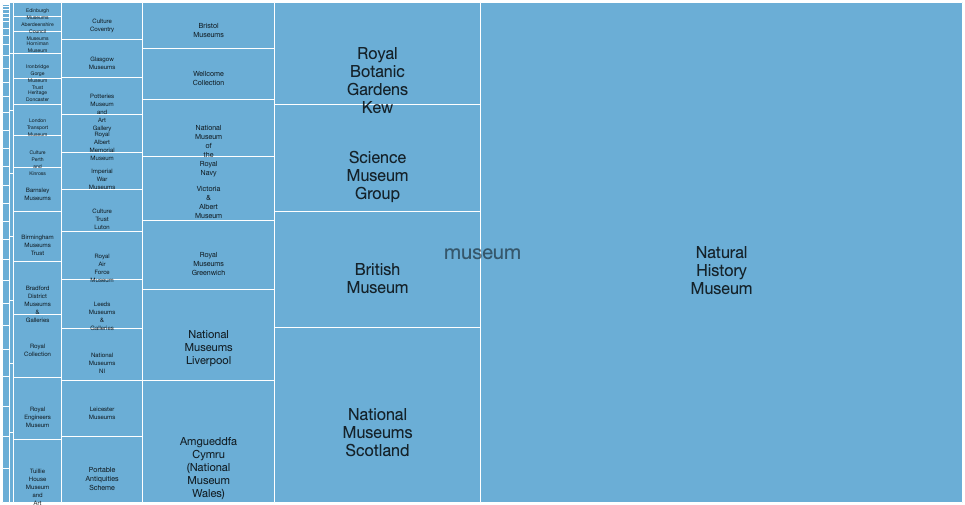

In [355]:
from IPython.display import display
import json
display({"application/vnd.vega.v5+json": json.loads(mus_treemap_spec)},
        metadata={
    "application/vnd.vegalite.v5+json": {
        "embed_options": {
            "actions": False
        }
    }
},  raw=True)


An overview of how the UK National Collection is formed, broken down by type of holding public institution:
  * Museum
  * Gallery
  * Library
  * Universities (which can include a Museum, Gallery, Libraries and Archives)

And not yet featuring Archives as handling the hierarchical nature of archive cataloguing brings up more complexity that has not yet been resolved.

This type classification, like much in this area, is somewhat ill-defined; most museums and galleries also have an archive and many also have library items. To give an alternative lower level view, other notebooks will try to break collections down by sub-type, so all the library collections (either at a library institution or a library collection at a museum/gallery/university) are counted together. As with many datasets, there are many different views that can be taken of the data and each brings different insights (and biases), there is no one view that can reveal all facts in a single glance.